# National tourism promotion:

# Data Modeling

This notebook includes the First part of the Data Modeling - 5.1	Comparison Before and After Pandemic; Type of Trip, Reviews and COVID-19 Impact; Frequent Itemset Associations (Market Basket Analysis): - And a Detail Analysis for Portugal in each point.

In [ ]:
#pip install plotly
#pip install plotly geopandas
#pip install mlxtend
#pip install apyori

In [1]:
# Packages
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
from math import ceil
from datetime import datetime
import pycountry
import time
import langid
import re
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import matplotlib.ticker as mtick
import prince
import plotly.express as px
import plotly.express as px
import geopandas as gpd
import plotly.graph_objects as go 
from matplotlib.ticker import FuncFormatter
from sklearn.cluster import KMeans

In [2]:
def get_country_info(iso_code):
    try:
        country = pycountry.countries.get(alpha_2=iso_code)
        if country:
            return country.name, country.alpha_3
        else:
            return "Country not found", None
    except Exception as e:
        return str(e), None

In [3]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [4]:
#dataframe with the first sheet of the europwTop100 excel 
df = pd.read_excel('reviews_clean.xlsx', engine="openpyxl")

In [5]:
df.head(1)

localID  globalRating  positionOnRanking  totalReviews             userName  \
0  MAG013           4.5                  1         34353  #1 Best@Number1Best   

                   userLocation  userContributions tripType reviewWritten  \
0  Ruwais, United Arab Emirates                 49  Friends    2019-01-11   

  reviewVisited  ...  userISOCode  \
0    2018-08-01  ...           AE   

                                  reviewFullText_agg         Name  Country  \
0  There’s not much “sightseeing” in Brussels, wh...  Grand Place  Belgium   

  ISO holiday  holiday_name  Year  Month  Day  
0  BE       0            No  2018      8    1  

[1 rows x 21 columns]

### DataFrames

In [6]:
world_visitors = df['userISOCode'].value_counts().reset_index()
world_visitors.columns = ['userISOCode', 'EntryCount']

In [7]:
# Adding 'country' and 'iso_alpha3' columns
world_visitors[['country', 'iso_alpha3']] = world_visitors['userISOCode'].apply(lambda x: pd.Series(get_country_info(x)))

In [8]:
df_filtered = df[df['Year'] >= 2019].copy()
df_filtered['Period'] = 'Before COVID'
df_filtered.loc[df_filtered['reviewVisited'] >= '2020-03-03', 'Period'] = 'After COVID'
columns_to_drop = ['userLocation', 'reviewWritten', 'reviewFullText_agg', 'holiday', 'holiday_name']
df_filtered = df_filtered.drop(columns=columns_to_drop)
df_filtered = df_filtered.merge(world_visitors[['userISOCode', 'country', 'iso_alpha3']], 
                              left_on='userISOCode', right_on='userISOCode', how='left')
df_filtered = df_filtered.rename(columns={'country': 'user_country', 'iso_alpha3': 'user_iso_alpha3'})

In [9]:
df_filtered['Season'] = np.select(
    [
        (df_filtered['Month'].between(3, 5)),  # Spring (March, April, May)
        (df_filtered['Month'].between(6, 8)),  # Summer (June, July, August)
        (df_filtered['Month'].between(9, 11)),  # Autumn/Fall (September, October, November)
        (df_filtered['Month'].isin([12, 1, 2]))  # Winter (December, January, February)
    ],
    ['Spring', 'Summer', 'Autumn', 'Winter'],
    default='Unknown'
)

In [10]:
df_filtered.head(1)

localID  globalRating  positionOnRanking  totalReviews  \
0  MAG013           4.5                  1         34353   

                               userName  userContributions tripType  \
0  #travelswithhugodog@ajotraveller2016                 81      NaN   

  reviewVisited  reviewRating userISOCode         Name  Country ISO  Year  \
0    2019-07-01             5          GB  Grand Place  Belgium  BE  2019   

   Month  Day        Period    user_country user_iso_alpha3  Season  
0      7    1  Before COVID  United Kingdom             GBR  Summer

## 1. Pandemic effect:

In [11]:
monthly_visited = df_filtered.groupby(['Year', 'Month']).size().reset_index(name='Count')
covid_impact_index = monthly_visited.index[
    (monthly_visited['Year'].astype(str) == '2020') & (monthly_visited['Month'].astype(str) == '3')
].tolist()

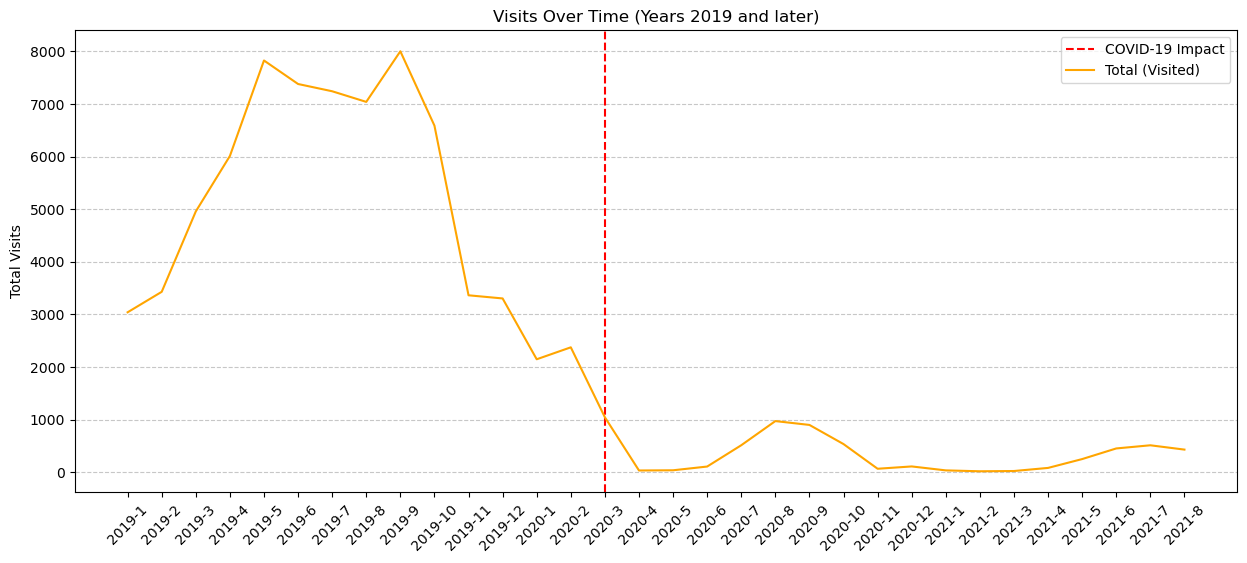

In [12]:
# Plotting with COVID-19 Impact line
plt.figure(figsize=(15, 6))
plt.axvline(x=covid_impact_index[0], color='red', linestyle='--', label='COVID-19 Impact')
sns.lineplot(x=monthly_visited.index,
             y=monthly_visited['Count'], label='Total (Visited)', color='orange')
month_labels = [f"{year}-{month}" for year, month in zip(monthly_visited['Year'], monthly_visited['Month'])]
plt.xticks(monthly_visited.index, month_labels, rotation=45)
plt.title('Visits Over Time (Years 2019 and later)')
plt.ylabel('Total Visits')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [13]:
df_2019_2020 = df[df['Year'].isin([2019, 2020])]
monthly_counts = df_2019_2020.groupby(['Year', 'Month']).size().unstack()
# Variação % entre 2019 e 2020
monthly_variation = (monthly_counts.loc[2020, :] - monthly_counts.loc[2019, :]) / monthly_counts.loc[2019, :] * 100

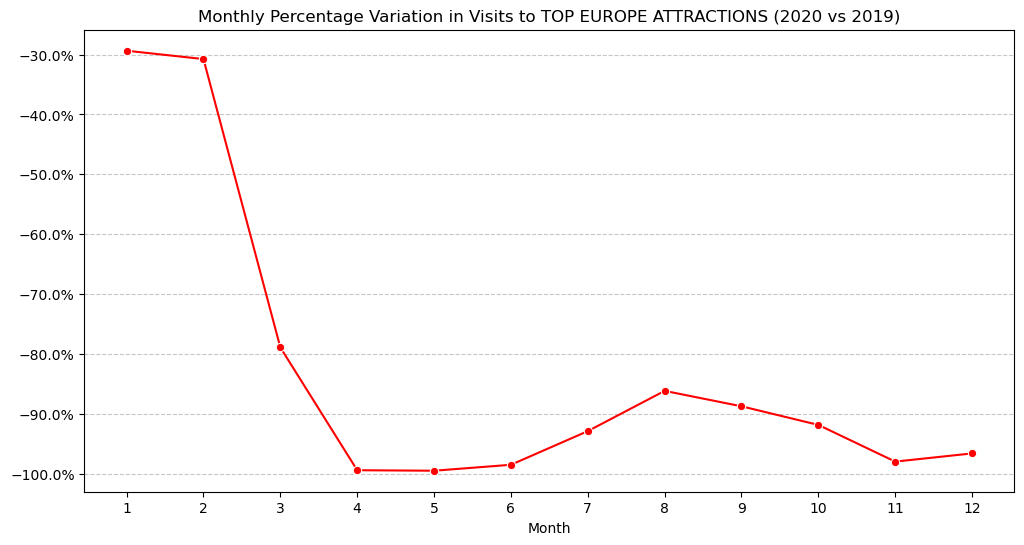

In [14]:
#Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_variation.index, y=monthly_variation.values, marker='o', color='red')
plt.xticks(monthly_variation.index)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.title('Monthly Percentage Variation in Visits to TOP EUROPE ATTRACTIONS (2020 vs 2019)')
plt.xlabel('Month')
plt.show()

In [15]:
for month, value in monthly_variation.items():
    print(f'{month}: {value:.2f}%')

1: -29.36%
2: -30.75%
3: -78.91%
4: -99.42%
5: -99.50%
6: -98.51%
7: -92.89%
8: -86.17%
9: -88.74%
10: -91.85%
11: -97.98%
12: -96.61%


In [16]:
df_filtered["reviewVisited"].max()

Timestamp('2021-08-20 00:00:00')

In [17]:
visits_2019 = df_filtered[(df_filtered['Year'] == 2019) & (df_filtered['Month'] < 8)]
visits_2020 = df_filtered[(df_filtered['Year'] == 2020) & (df_filtered['Month'] < 8)]
visits_2021 = df_filtered[(df_filtered['Year'] == 2021) & (df_filtered['Month'] < 8)]


monthly_counts_2019 = visits_2019.groupby(['Year', 'Month']).size().unstack()
monthly_counts_2020 = visits_2020.groupby(['Year', 'Month']).size().unstack()
monthly_counts_2021 = visits_2021.groupby(['Year', 'Month']).size().unstack()

In [18]:
monthly_counts_2019

Month     1     2     3     4     5     6     7
Year                                           
2019   3042  3431  4959  6013  7828  7381  7243

In [19]:
monthly_counts_2020

Month     1     2     3   4   5    6    7
Year                                     
2020   2149  2376  1046  35  39  110  515

In [20]:
monthly_counts_2021

Month   1   2   3   4    5    6    7
Year                                
2021   37  20  25  84  252  454  514

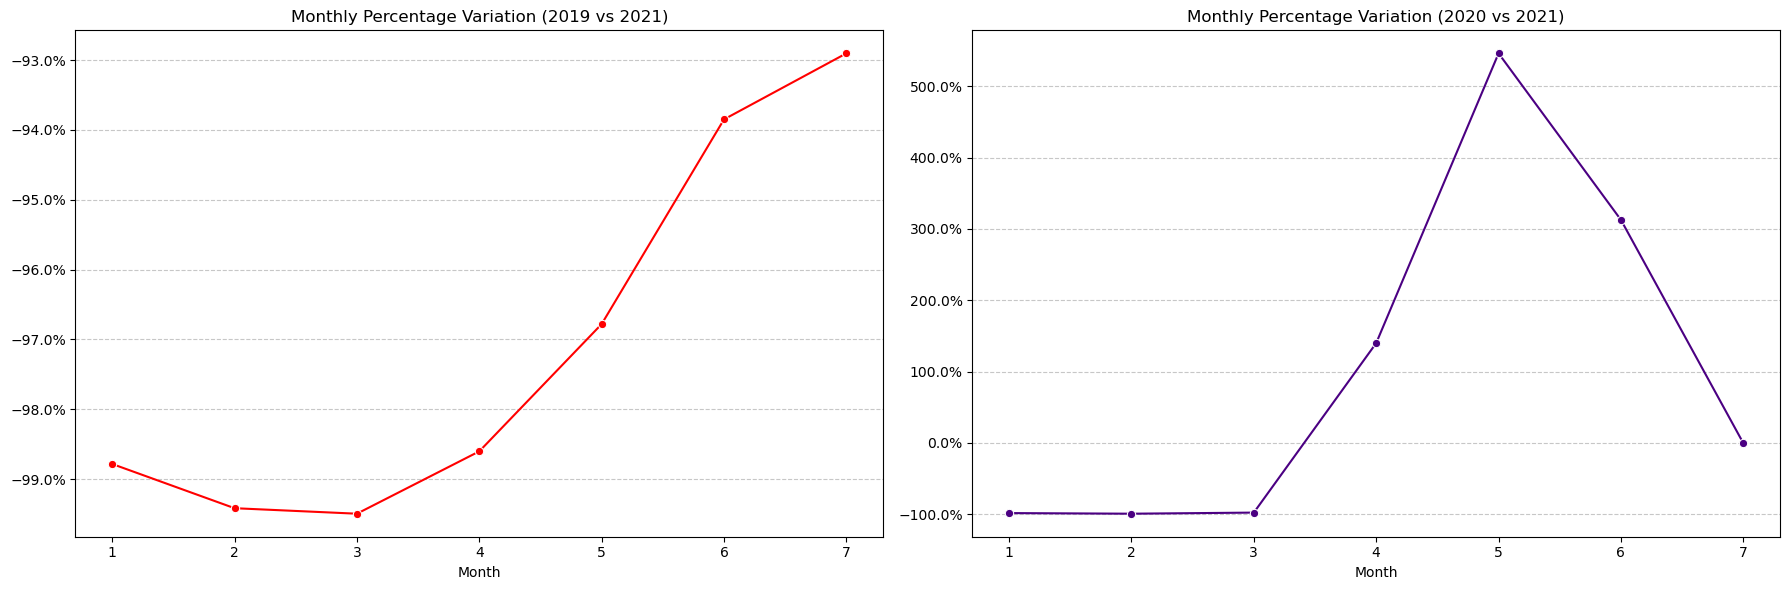

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# Var % bt 2019 and 2021
monthly_variation_2019_2021 = ((monthly_counts_2021.loc[2021, :] / monthly_counts_2019.loc[2019, :]) -1) * 100

sns.lineplot(x=monthly_variation_2019_2021.index, y=monthly_variation_2019_2021.values, marker='o', color='red', ax=axes[0])
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)
axes[0].set_title('Monthly Percentage Variation (2019 vs 2021)')
axes[0].set_xlabel('Month')

# Var % bt 2020 and 2021
monthly_variation_2020_2021 = ((monthly_counts_2021.loc[2021, :] / monthly_counts_2020.loc[2020, :]) -1) * 100

sns.lineplot(x=monthly_variation_2020_2021.index, y=monthly_variation_2020_2021.values, marker='o', color='indigo', ax=axes[1])
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
axes[1].grid(True, axis='y', linestyle='--', alpha=0.7)
axes[1].set_title('Monthly Percentage Variation (2020 vs 2021)')
axes[1].set_xlabel('Month')

plt.tight_layout()
plt.show()

Despite deployment of COVID-19 vaccines, Europe became the pandemic's epicentre once again in 2021.So no suprise the scenario not show a sgnificant improvment just yet

### Season

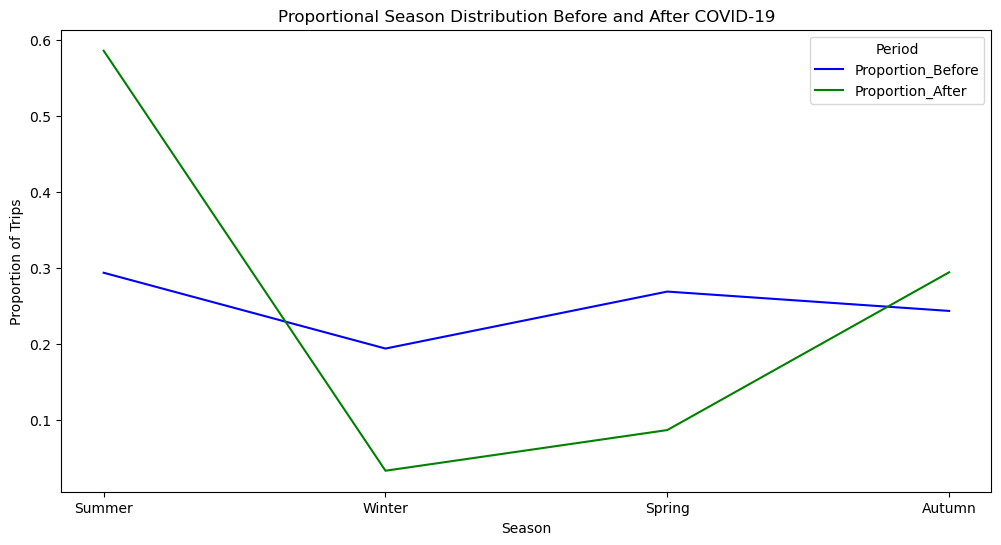

In [22]:
df_filtered['Season'] = pd.Categorical(df_filtered['Season'], categories=df_filtered['Season'].unique(), ordered=True)

# trips per period
trips_count_before_covid = df_filtered[df_filtered['Period'] == 'Before COVID']['Season'].value_counts().rename_axis('Season').reset_index(name='Count')
trips_count_after_covid = df_filtered[df_filtered['Period'] == 'After COVID']['Season'].value_counts().rename_axis('Season').reset_index(name='Count')
season_counts = pd.merge(trips_count_before_covid, trips_count_after_covid, on='Season', how='outer', suffixes=('_Before', '_After'))
season_counts = season_counts.fillna(0)

season_counts['Proportion_Before'] = season_counts['Count_Before'] / season_counts['Count_Before'].sum()
season_counts['Proportion_After'] = season_counts['Count_After'] / season_counts['Count_After'].sum()


season_counts = season_counts.melt(id_vars='Season', value_vars=['Proportion_Before', 'Proportion_After'], var_name='Period', value_name='Proportion')
# plot (stacked)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Season', y='Proportion', hue='Period', data=season_counts, palette={'Proportion_Before': 'blue', 'Proportion_After': 'green'})
plt.title('Proportional Season Distribution Before and After COVID-19')
plt.xlabel('Season')
plt.ylabel('Proportion of Trips')
plt.show()

## 2. Visitor origins:

In [23]:
world_visitors.head(1)

userISOCode  EntryCount         country iso_alpha3
0          GB       27421  United Kingdom        GBR

In [24]:
for year in [2019, 2020, 2021]:
    column_name = f'count_{year}'
    world_visitors[column_name] = df_filtered[df_filtered['Year'] == year]['userISOCode'].value_counts().reindex(world_visitors['userISOCode']).fillna(0).values

In [25]:
world_visitors['Country_weight'] = world_visitors['EntryCount'] / (world_visitors['EntryCount'].sum())

In [26]:
world_visitors.head(1)

userISOCode  EntryCount         country iso_alpha3  count_2019  count_2020  \
0          GB       27421  United Kingdom        GBR     21177.0      4086.0   

   count_2021  Country_weight  
0       910.0         0.37994

In [27]:
fig = go.Figure(data=go.Choropleth(
    locations=world_visitors['iso_alpha3'],
    z=world_visitors['EntryCount'],
    text=world_visitors['country'],
    colorscale='viridis',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='black',
    marker_line_width=0.5,
    colorbar_tickprefix='',
    colorbar_title='Count of<br>Visitors'
))

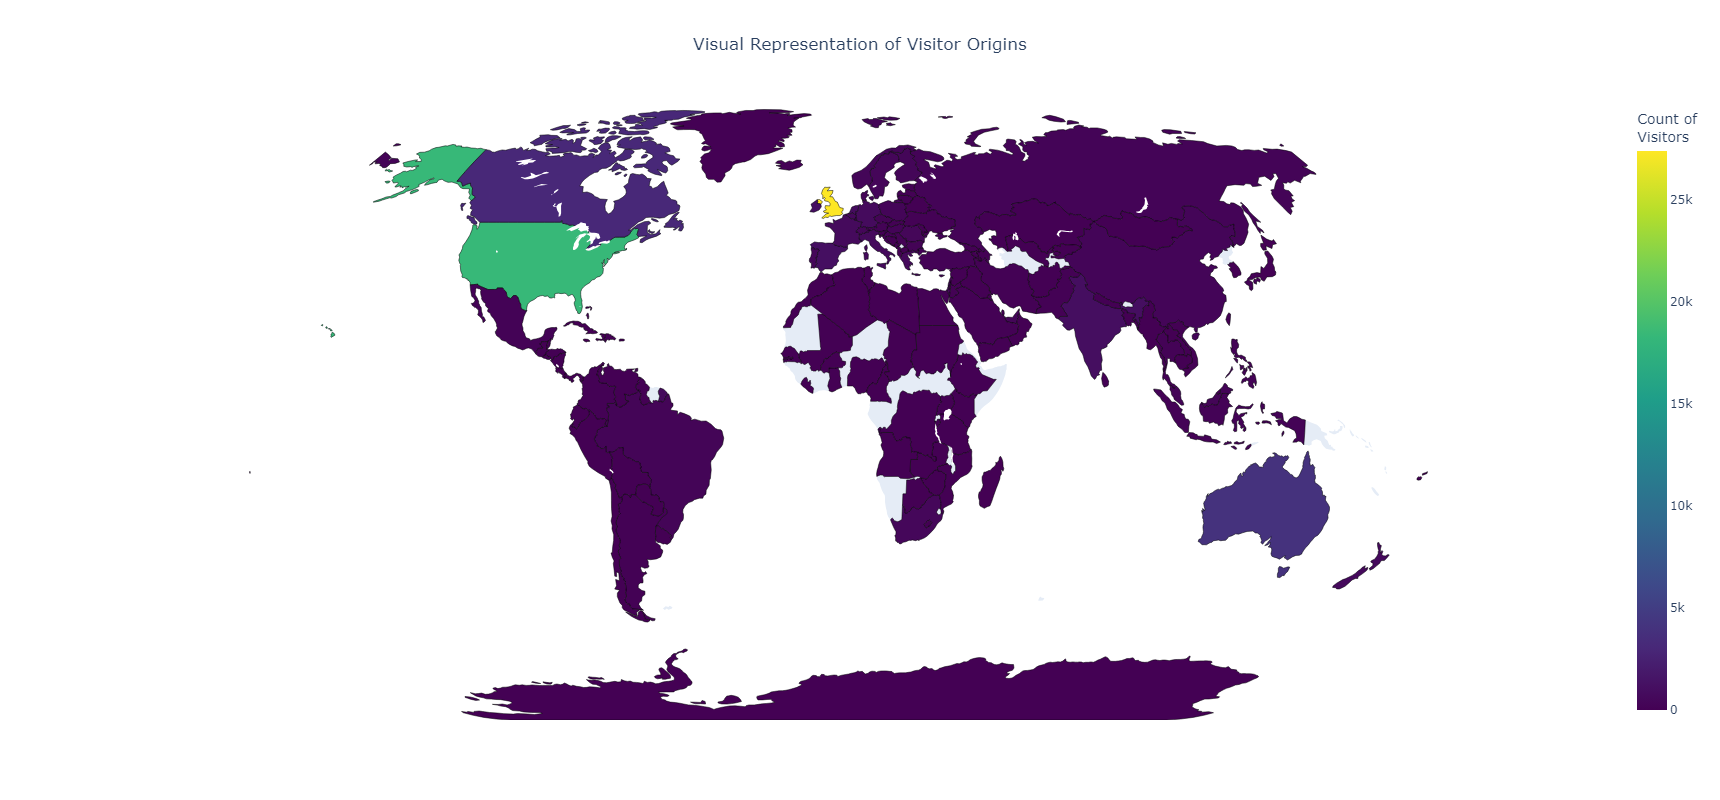

In [28]:
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='natural earth'
    ),
    width=1200,  
    height=800   
)

fig.update_layout(
    title='Visual Representation of Visitor Origins',
    title_x=0.5,
)
fig.show()

#### In this phase, it is noticeable that our dataset is language biased. Since the reviews were all in English, most of the reviews came from people who are from English-speaking countries.

We can see the individual count of each country by passing the mouse on the plot.

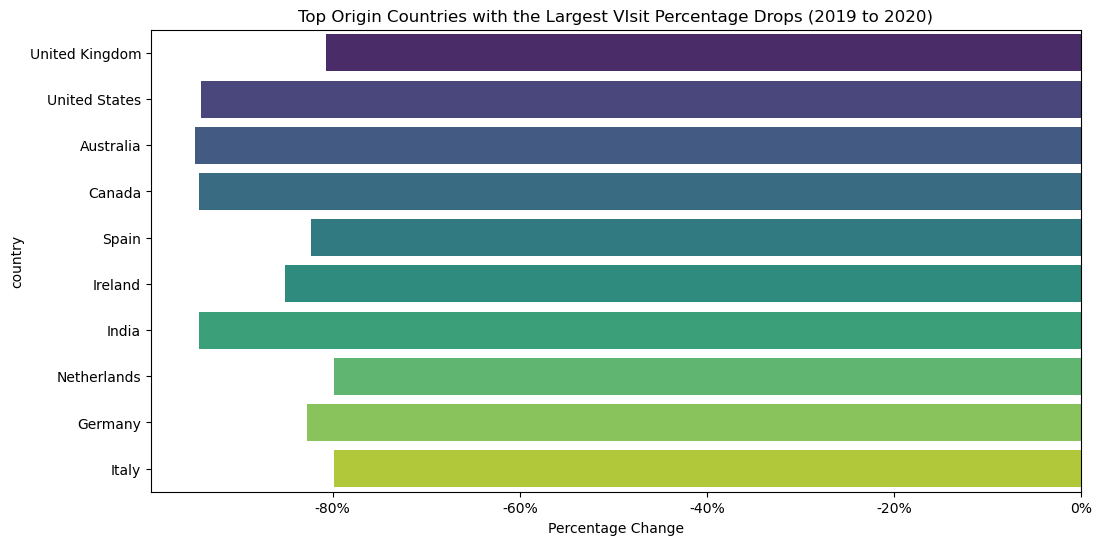

In [29]:
# change from 2019 to 2020
world_visitors['percentage_change_2019_2020'] = ((world_visitors['count_2020'] - world_visitors['count_2019']) / world_visitors['count_2019']) * 100
# top 10 countries with the highest weight
top_countries = world_visitors.nlargest(10, 'Country_weight')

# Plot with top countries with the largest percentage drops and highest weight in the dataset
plt.figure(figsize=(12, 6))
sns.barplot(x='percentage_change_2019_2020', y='country', data=top_countries, palette='viridis')
plt.title('Top Origin Countries with the Largest VIsit Percentage Drops (2019 to 2020)')
plt.xlabel('Percentage Change')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.show()

In [30]:
df_filtered.head(1)

localID  globalRating  positionOnRanking  totalReviews  \
0  MAG013           4.5                  1         34353   

                               userName  userContributions tripType  \
0  #travelswithhugodog@ajotraveller2016                 81      NaN   

  reviewVisited  reviewRating userISOCode         Name  Country ISO  Year  \
0    2019-07-01             5          GB  Grand Place  Belgium  BE  2019   

   Month  Day        Period    user_country user_iso_alpha3  Season  
0      7    1  Before COVID  United Kingdom             GBR  Summer

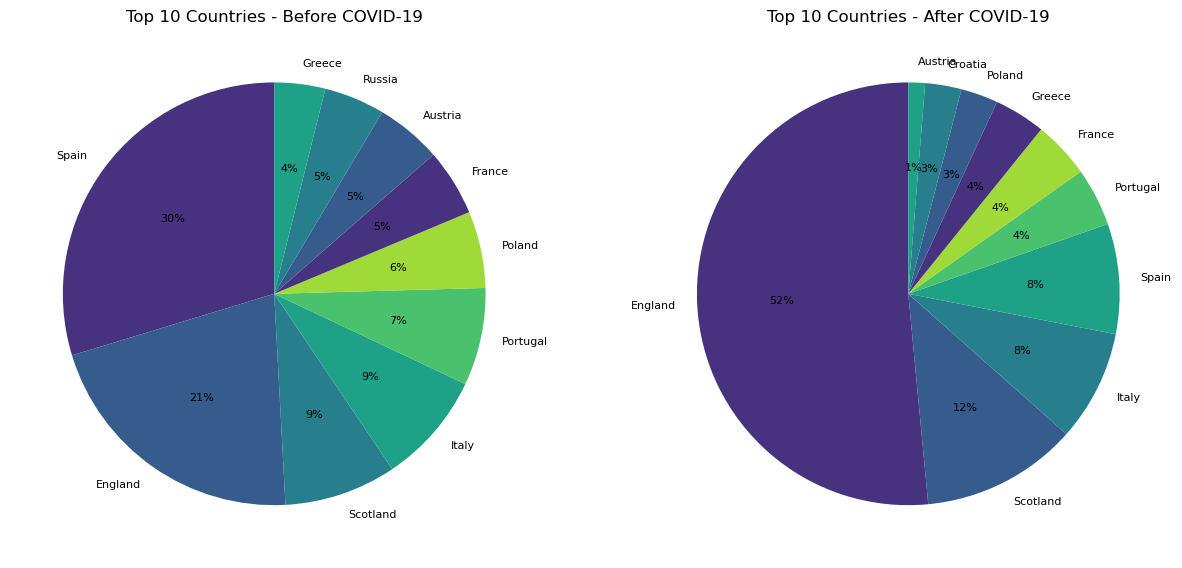

In [32]:
# Before COVID-19
top_countries_pre = df_filtered['Country'][df_filtered["Period"]=='Before COVID'].value_counts().head(10)
# After COVID-19
top_countries_pos = df_filtered['Country'][df_filtered["Period"]=='After COVID'].value_counts().head(10)

# ubplots
plt.figure(figsize=(15, 8))  
# Subplot for Before COVID-19
plt.subplot(1, 2, 1)
sns.set_palette("viridis")  
plt.pie(top_countries_pre, labels=top_countries_pre.index, autopct='%1.0f%%', startangle=90, textprops={'fontsize': 8})  
plt.title('Top 10 Countries - Before COVID-19')
# Subplot for After COVID-19
plt.subplot(1, 2, 2)
sns.set_palette("viridis")  
plt.pie(top_countries_pos, labels=top_countries_pos.index, autopct='%1.0f%%', startangle=90, textprops={'fontsize': 8})  
plt.title('Top 10 Countries - After COVID-19')
plt.show()

#### Since we have so much tourists from UK its possible that the covid motivate the Domestic Tourism.

# Domestic Tourism

Not surprisingly, we observe a significant increase in domestic tourism, indicating that users are exploring more of their own countries due to border restriction

In [33]:
attraction_iso_codes = df_filtered['ISO'].unique()

before_covid = df_filtered[(df_filtered['Period'] == 'Before COVID') & (df_filtered['userISOCode'].isin(attraction_iso_codes))].copy()
after_covid = df_filtered[(df_filtered['Period'] == 'After COVID') & (df_filtered['userISOCode'].isin(attraction_iso_codes))].copy()

# ADDing bool column for 'userISOCode' == 'ISO'
before_covid['is_same_iso'] = before_covid['userISOCode'] == before_covid['ISO']
after_covid['is_same_iso'] = after_covid['userISOCode'] == after_covid['ISO']

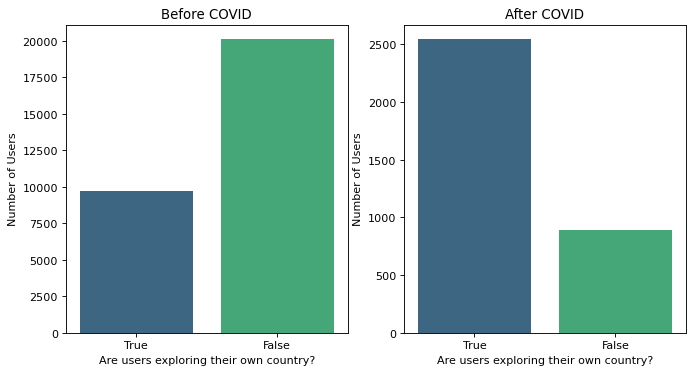

In [34]:
true_count_before = (before_covid['is_same_iso'] == True).sum()
false_count_before = before_covid.shape[0] - true_count_before
true_count_after = (after_covid['is_same_iso'] == True).sum()
false_count_after = after_covid.shape[0] - true_count_after

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=80)

# 'Before COVID'
sns.barplot(x=['True', 'False'], y=[true_count_before, false_count_before], palette="viridis", ax=axes[0])
axes[0].set_title('Before COVID')
axes[0].set_xlabel('Are users exploring their own country?')
axes[0].set_ylabel('Number of Users')

#'After COVID'
sns.barplot(x=['True', 'False'], y=[true_count_after, false_count_after], palette="viridis", ax=axes[1])
axes[1].set_title('After COVID')
axes[1].set_xlabel('Are users exploring their own country?')
axes[1].set_ylabel('Number of Users')

plt.show()

### Portugal case

Let's specifically analyze the impact of the pandemic on visits in Portugal. To do this, we'll filter the original dataframe and keep only the entries for visits where `Country` == 'Portugal' - VISIT DATA AFTER 2019, since prior to this, the visit date does not correspond to the date of writing the review and is not a representative measure, as people usually provide reviews close to the visit.

In [35]:
portugal_df = df[(df['Country'] == 'Portugal') & (df['Year'] >= 2019)].copy()
portugal_df = portugal_df.merge(world_visitors[['userISOCode', 'country', 'iso_alpha3']], 
                              left_on='userISOCode', right_on='userISOCode', how='left')

portugal_df = portugal_df.rename(columns={'country': 'user_country', 'iso_alpha3': 'user_iso_alpha3'})
portugal_df = portugal_df.drop(columns=['totalReviews', 'userName', 'userLocation', 'reviewFullText_agg', 'reviewWritten'])

portugal_df.head(1)

localID  globalRating  positionOnRanking  userContributions tripType  \
0  MAG010           4.0                  6                185  Couples   

  reviewVisited  reviewRating userISOCode            Name   Country ISO  \
0    2019-04-01             4         NaN  Torre de Belém  Portugal  PT   

   holiday holiday_name  Year  Month  Day user_country user_iso_alpha3  
0        0           No  2019      4    1          NaN             NaN

#### Portugal Enthusiasts: Unveiling Their Origins

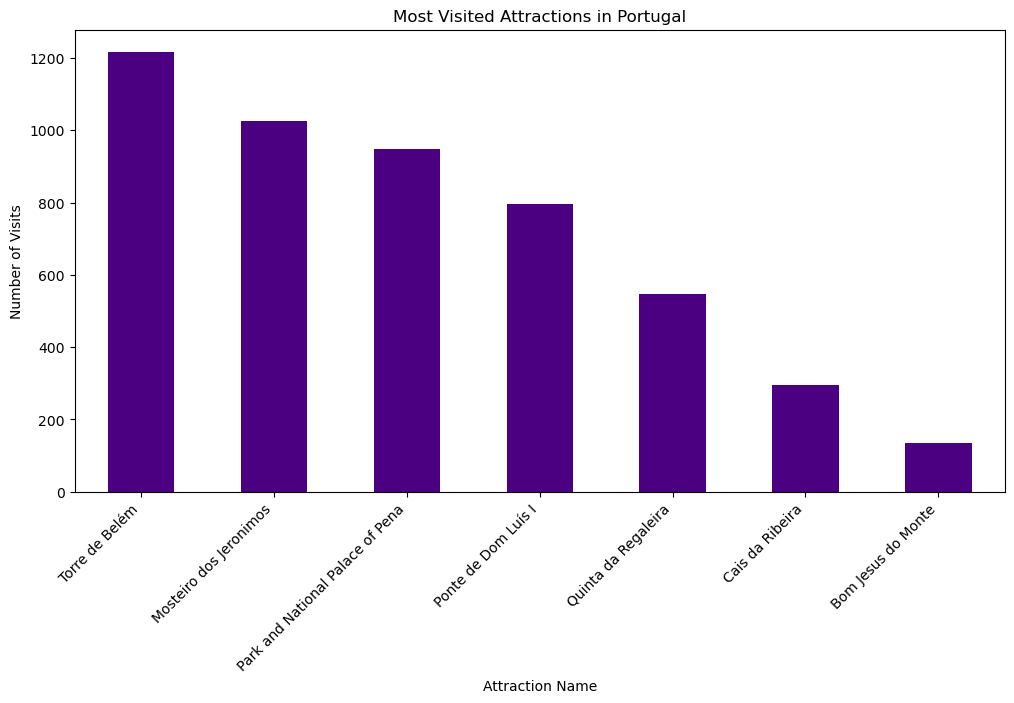

In [36]:
attraction_counts = portugal_df['Name'].value_counts()

plt.figure(figsize=(12, 6))
attraction_counts.plot(kind='bar', color='indigo')
plt.title('Most Visited Attractions in Portugal')
plt.xlabel('Attraction Name')
plt.ylabel('Number of Visits')
plt.xticks(rotation=45, ha='right')
plt.show()

In [37]:
portugal_df['userISOCode'].value_counts().reset_index().head(10)

index  userISOCode
0    US         1194
1    GB         1109
2    CA          347
3    AU          192
4    PT          173
5    IE          114
6    NL           87
7    ES           69
8    IL           59
9    IT           56

The top countries contributing to tourism in Portugal are led by the United States with 1194 visits, followed closely by the United Kingdom at 1109 visits. Canada takes the third spot with 347 visits, while Australia, Portugal itself, and Ireland secure positions four to six, each contributing significantly to the tourism landscape. 

In [38]:
visits_count_PT = portugal_df['userISOCode'].value_counts().reset_index()
visits_count_PT.columns = ['userISOCode', 'EntryCount']

# Merge com world_visitors para obter informações adicionais
visits_count_PT = visits_count_PT.merge(world_visitors[['userISOCode', 'country', 'iso_alpha3']], 
                                  left_on='userISOCode', right_on='userISOCode', how='left') 

# Plotar o gráfico
fig = go.Figure(data=go.Choropleth(
    locations=visits_count_PT['iso_alpha3'],
    z=visits_count_PT['EntryCount'],
    text=visits_count_PT['country'],
    colorscale='viridis',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='black',
    marker_line_width=0.5,
    colorbar_tickprefix='',
    colorbar_title='Count of<br>Visitors'
))

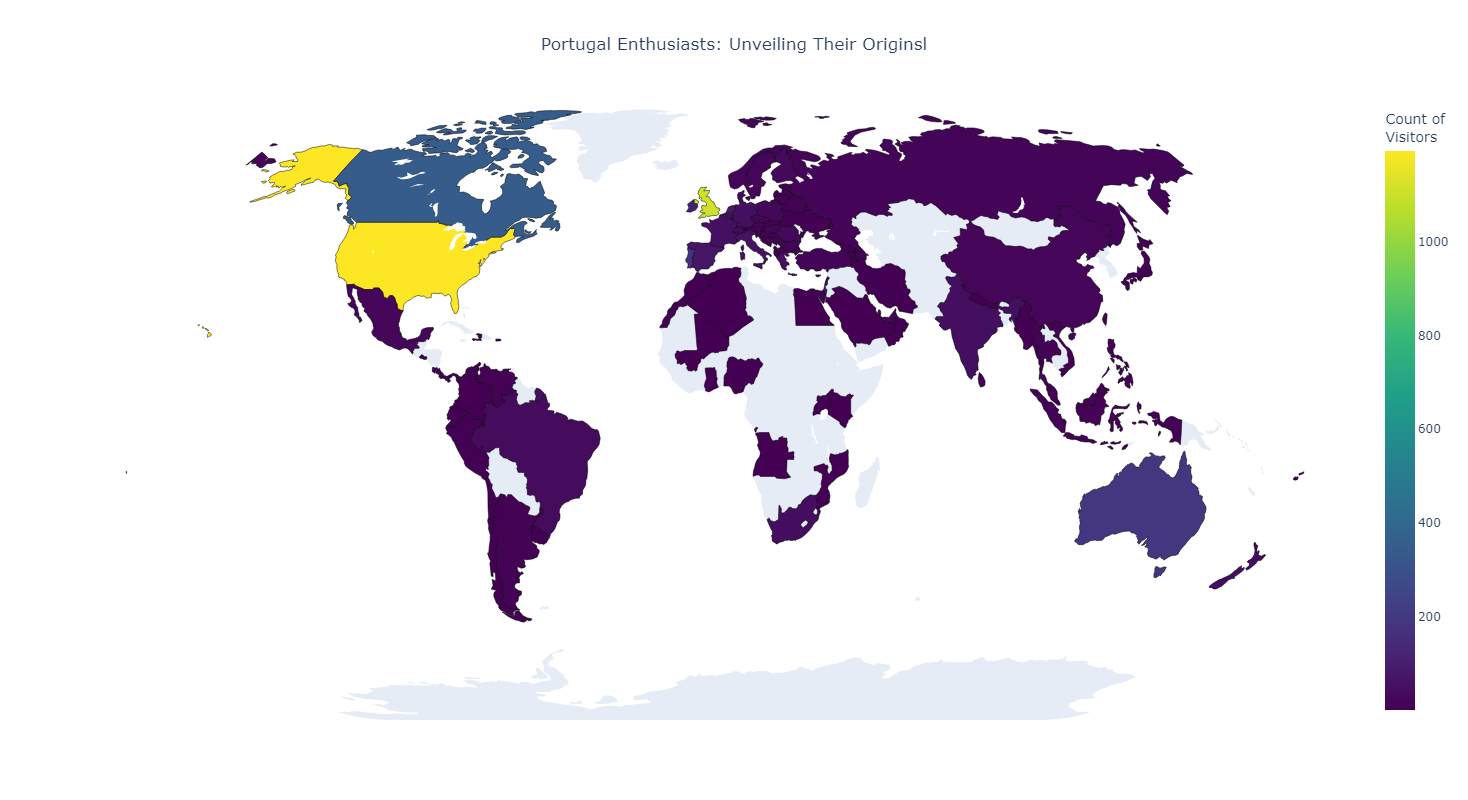

In [39]:
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='natural earth'
    ),
    width=1200,  
    height=800,
    title='Portugal Enthusiasts: Unveiling Their Originsl',
    title_x=0.5,
)
fig.show()

In [75]:
total_visits_2019 = portugal_df[portugal_df['Year'] == 2019]['reviewVisited'].count()
total_visits_2020 = portugal_df[portugal_df['Year'] == 2020]['reviewVisited'].count()
drop_percentage = ((total_visits_2020 - total_visits_2019) / total_visits_2019) * 100

print(f'Total Visits to Portugal in 2019: {total_visits_2019}')
print(f'Total Visits to Portugal in 2020: {total_visits_2020}')
print(f'Drop in Total Visits from 2019 to 2020: {drop_percentage:.2f}%')

Total Visits to Portugal in 2019: 4266
Total Visits to Portugal in 2020: 627
Drop in Total Visits from 2019 to 2020: -85.30%


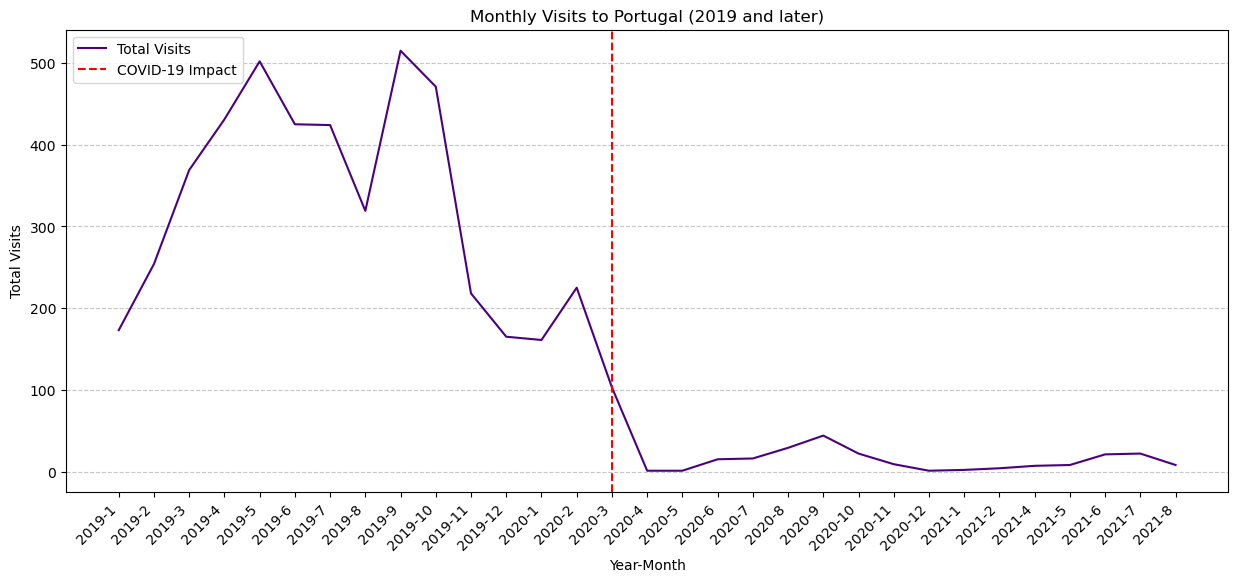

In [40]:
monthly_visited_portugal = portugal_df.groupby(['Year', 'Month']).size().reset_index(name='Count')
monthly_visited_portugal['YearMonth'] = monthly_visited_portugal['Year'].astype(str) + '-' + monthly_visited_portugal['Month'].astype(str)
covid_impact_pt = monthly_visited_portugal.query('Year == 2020 & Month == 3').index.tolist()

# Plotting with COVID-19 Impact line
plt.figure(figsize=(15, 6))
sns.lineplot(x='YearMonth', y='Count', data=monthly_visited_portugal, label='Total Visits', color='indigo')
plt.axvline(x=covid_impact_pt[0], color='red', linestyle='--', label='COVID-19 Impact')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Year-Month')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.title('Monthly Visits to Portugal (2019 and later)')
plt.ylabel('Total Visits')

plt.show()

In [41]:
df_europe_2019_2020 = df[(df['Country'] != 'Portugal') & df['Year'].isin([2019, 2020])]
df_portugal_2019_2020 = df[(df['Country'] == 'Portugal') & df['Year'].isin([2019, 2020])]

# monthly percentage variation between 2019 and 2020 for Europe
monthly_variation_europe = (
    (df_europe_2019_2020.groupby(['Year', 'Month']).size().unstack().loc[2020, :] - 
     df_europe_2019_2020.groupby(['Year', 'Month']).size().unstack().loc[2019, :]) / 
    df_europe_2019_2020.groupby(['Year', 'Month']).size().unstack().loc[2019, :] * 100
)

# monthly percentage variation between 2019 and 2020 for Portugal
monthly_variation_portugal = (
    (df_portugal_2019_2020.groupby(['Year', 'Month']).size().unstack().loc[2020, :] - 
     df_portugal_2019_2020.groupby(['Year', 'Month']).size().unstack().loc[2019, :]) / 
    df_portugal_2019_2020.groupby(['Year', 'Month']).size().unstack().loc[2019, :] * 100
)

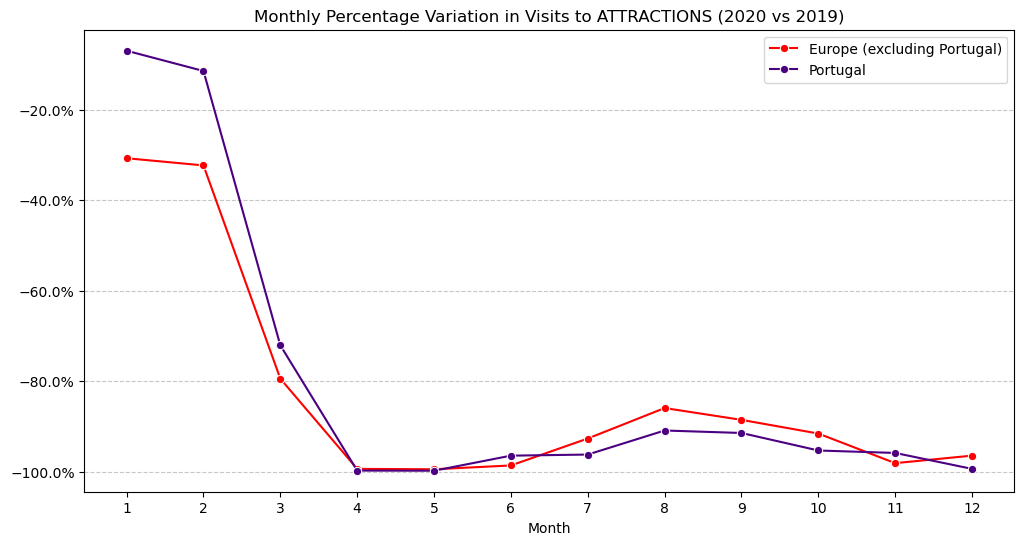

In [42]:
# Plot the variation for Europe and Portugal
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_variation_europe.index, y=monthly_variation_europe.values, marker='o', color='red', label='Europe (excluding Portugal)')
sns.lineplot(x=monthly_variation_portugal.index, y=monthly_variation_portugal.values, marker='o', color='indigo', label='Portugal')
plt.xticks(monthly_variation_europe.index)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.title('Monthly Percentage Variation in Visits to ATTRACTIONS (2020 vs 2019)')
plt.xlabel('Month')
plt.legend()
plt.show()

In [43]:
portugal_df

localID  globalRating  positionOnRanking  userContributions tripType  \
0     MAG010           4.0                  6                185  Couples   
1     MAG010           4.0                  6                 21  Couples   
2     MAG010           4.0                  6                 16  Couples   
3     MAG010           4.0                  6                 20      NaN   
4     MAG010           4.0                  6                 17      NaN   
...      ...           ...                ...                ...      ...   
4960  MAG049           4.5                  3                 72      NaN   
4961  MAG049           4.5                  3                 38      NaN   
4962  MAG049           4.5                  3                800  Couples   
4963  MAG049           4.5                  3                115      NaN   
4964  MAG049           4.5                  3                314  Couples   

     reviewVisited  reviewRating userISOCode             Name   Country ISO  \
0       2019-04-01             4         NaN   Torre de Belém  Portugal  PT   
1       2020-02-01             4          GB   Torre de Belém  Portugal  PT   
2       2019-03-01             5          MT   Torre de Belém  Portugal  PT   
3       2019-05-01             5          US   Torre de Belém  Portugal  PT   
4       2019-09-01             5          GB   Torre de Belém  Portugal  PT   
...            ...           ...         ...              ...       ...  ..   
4960    2019-10-01             5          GB  Cais da Ribeira  Portugal  PT   
4961    2020-03-01             5          GB  Cais da Ribeira  Portugal  PT   
4962    2019-06-01             5          CA  Cais da Ribeira  Portugal  PT   
4963    2019-05-01             5          US  Cais da Ribeira  Portugal  PT   
4964    2019-11-01             3          IL  Cais da Ribeira  Portugal  PT   

      holiday holiday_name  Year  Month  Day    user_country user_iso_alpha3  
0           0           No  2019      4    1             NaN             NaN  
1           0           No  2020      2    1  United Kingdom             GBR  
2           0           No  2019      3    1           Malta             MLT  
3           1    labor day  2019      5    1   United States             USA  
4           1           No  2019      9    1  United Kingdom             GBR  
...       ...          ...   ...    ...  ...             ...             ...  
4960        0           No  2019     10    1  United Kingdom             GBR  
4961        1           No  2020      3    1  United Kingdom             GBR  
4962        0           No  2019      6    1          Canada             CAN  
4963        1    labor day  2019      5    1   United States             USA  
4964        1    hallowmas  2019     11    1          Israel             ISR  

[4965 rows x 18 columns]

## Type of Trip, Reviews and Origin of Visitors: 

In [44]:
df_filtered.head(1)

localID  globalRating  positionOnRanking  totalReviews  \
0  MAG013           4.5                  1         34353   

                               userName  userContributions tripType  \
0  #travelswithhugodog@ajotraveller2016                 81      NaN   

  reviewVisited  reviewRating userISOCode         Name  Country ISO  Year  \
0    2019-07-01             5          GB  Grand Place  Belgium  BE  2019   

   Month  Day        Period    user_country user_iso_alpha3  Season  
0      7    1  Before COVID  United Kingdom             GBR  Summer

<Figure size 1500x600 with 0 Axes>

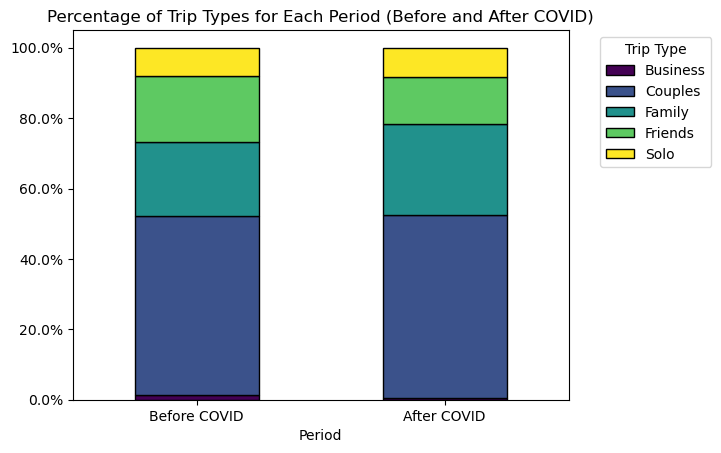

In [45]:
ordered_periods = ['Before COVID', 'After COVID']
df_filtered['Period'] = pd.Categorical(df_filtered['Period'], categories=ordered_periods, ordered=True)

# total trips for each period and trip type
Period_triptype = df_filtered.groupby(['Period', 'tripType']).size().reset_index(name='tripCount')

# total trips for each period
Period_total_trips = Period_triptype.groupby('Period')['tripCount'].sum().reset_index(name='totalTrips')

# percentage of each trip type for each period
triptype_percentages = pd.merge(Period_triptype, Period_total_trips, on='Period')
triptype_percentages['percentage'] = (triptype_percentages['tripCount'] / triptype_percentages['totalTrips']) * 100

# Plot 
triptype_percentages_pivot = triptype_percentages.pivot(index='Period', columns='tripType', values='percentage')
plt.figure(figsize=(15, 6))
ax = triptype_percentages_pivot.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))  
plt.title('Percentage of Trip Types for Each Period (Before and After COVID)')
plt.xlabel('Period')
plt.xticks(rotation=0)  # Ajuste o ângulo de rotação se necessário
plt.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

With this graph, we aimed to identify shifts in travel patterns, specifically focusing on changes in the percentage distribution of different trip types. We observed a slight percentage reduction in trips with friends, which typically involve larger groups gathering for social activities. This decline can be attributed to various factors, including the closure of nightclubs and a general decrease in large social gatherings due to the ongoing pandemic.
Conversely, there is a noticeable percentage increase in family trips, likely reflecting a shift towards more intimate and familial travel experiences. Additionally, there is a slight percentage rise in solo trips, suggesting a potential preference for individual travel, possibly due to safety concerns or personal preferences.
On the business front, there is a percentage decrease in business trips. The COVID-19 pandemic accelerated the adoption of remote work, rendering many business trips non-essential. The increased recognition of health risks associated with travel also contributed to this decline in business-related travel.

In [46]:
triptype_percentages_pivot

tripType      Business    Couples     Family    Friends      Solo
Period                                                           
Before COVID  1.370133  50.919665  20.954165  18.759980  7.996057
After COVID   0.575333  51.851852  25.818051  13.556275  8.198490

<Figure size 1500x600 with 0 Axes>

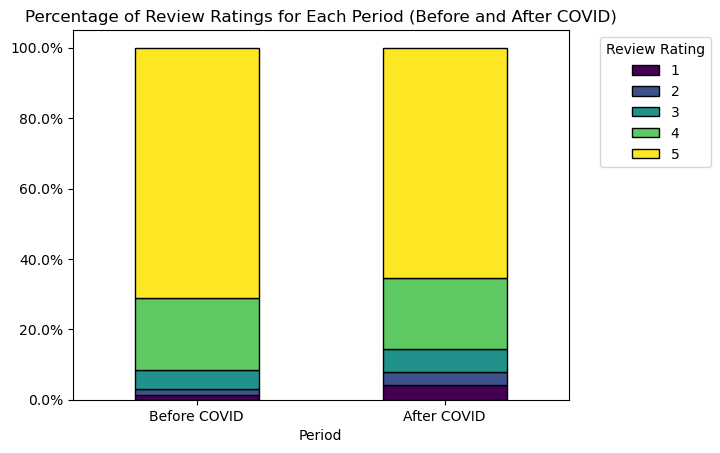

In [47]:
# total trips for each period and review rating
Period_reviewRating = df_filtered.groupby(['Period', 'reviewRating']).size().reset_index(name='reviewRatingCount')

# total review ratings for each period
Period_total_reviewRating = Period_reviewRating.groupby('Period')['reviewRatingCount'].sum().reset_index(name='totalReviewRatings')

# percentage of each review rating for each period
reviewRating_percentages = pd.merge(Period_reviewRating, Period_total_reviewRating, on='Period')
reviewRating_percentages['percentage'] = (reviewRating_percentages['reviewRatingCount'] / reviewRating_percentages['totalReviewRatings']) * 100

# Plot 
reviewRating_percentages_pivot = reviewRating_percentages.pivot(index='Period', columns='reviewRating', values='percentage')
plt.figure(figsize=(15, 6))
ax = reviewRating_percentages_pivot.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))  
plt.title('Percentage of Review Ratings for Each Period (Before and After COVID)')
plt.xlabel('Period')
plt.xticks(rotation=0)  # Adjust the rotation angle if needed
plt.legend(title='Review Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [48]:
reviewRating_percentages_pivot

reviewRating         1         2        3          4          5
Period                                                         
Before COVID  1.340762  1.607830  5.61385  20.394773  71.042785
After COVID   4.084424  3.654485  6.80086  20.011726  65.448505

We observe a noteworthy shift in the distribution of review ratings after the onset of the COVID-19 pandemic. Notably, negative reviews seem to have gained prominence during this period. This change could be associated with heightened concerns and potentially reflects a shift in customer sentiments post-COVID-19. 
The observed increase in negative reviews post-COVID-19 may be attributed to heightened concerns related to various aspects of the travel experience. Factors such as hygiene standards, crowd management, and the desire for shorter waiting times have become more salient considerations for travelers in the wake of the pandemic. Customers may now prioritize safety and efficiency, and any perceived shortcomings in these areas could contribute to a higher incidence of negative feedback. As expectations evolve in response to the ongoing global situation, businesses should proactively address these concerns to enhance customer satisfaction and adapt to the changing landscape of travel preferences.

### Portugal case

Now we are going to analyze how the pandemic has affected travel profiles or the reputation (in terms of ratings) of Portugal.

In [49]:
portugal_df['Period'] = 'Before COVID'
portugal_df.loc[portugal_df['reviewVisited'] >= '2020-03-03', 'Period'] = 'After COVID'
portugal_df.head(2)

localID  globalRating  positionOnRanking  userContributions tripType  \
0  MAG010           4.0                  6                185  Couples   
1  MAG010           4.0                  6                 21  Couples   

  reviewVisited  reviewRating userISOCode            Name   Country ISO  \
0    2019-04-01             4         NaN  Torre de Belém  Portugal  PT   
1    2020-02-01             4          GB  Torre de Belém  Portugal  PT   

   holiday holiday_name  Year  Month  Day    user_country user_iso_alpha3  \
0        0           No  2019      4    1             NaN             NaN   
1        0           No  2020      2    1  United Kingdom             GBR   

         Period  
0  Before COVID  
1  Before COVID

<Figure size 1500x600 with 0 Axes>

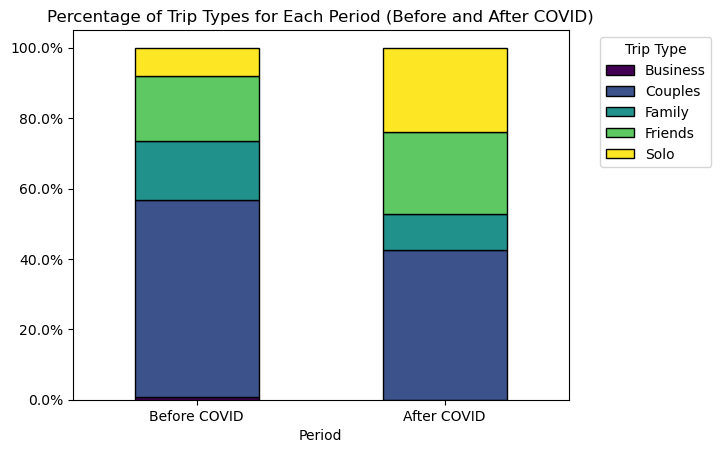

In [50]:
ordered_periods = ['Before COVID', 'After COVID']
portugal_df['Period'] = pd.Categorical(portugal_df['Period'], categories=ordered_periods, ordered=True)

# total trips for each period and type
Period_triptype = portugal_df.groupby(['Period', 'tripType']).size().reset_index(name='tripCount')

# total trips with type for each period
Period_total_trips = Period_triptype.groupby('Period')['tripCount'].sum().reset_index(name='totalTrips')

# % trip type for each period
triptype_percentages = pd.merge(Period_triptype, Period_total_trips, on='Period')
triptype_percentages['percentage'] = (triptype_percentages['tripCount'] / triptype_percentages['totalTrips']) * 100

# Plot
triptype_percentages_pivot = triptype_percentages.pivot(index='Period', columns='tripType', values='percentage')
plt.figure(figsize=(15, 6))
ax = triptype_percentages_pivot.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))  
plt.title('Percentage of Trip Types for Each Period (Before and After COVID)')
plt.xlabel('Period')
plt.xticks(rotation=0)  # Ajuste o ângulo de rotação se necessário
plt.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [51]:
triptype_percentages_pivot

tripType      Business    Couples     Family    Friends       Solo
Period                                                            
Before COVID  0.827459  55.930126  16.702421  18.387987   8.152007
After COVID   0.000000  42.592593  10.185185  23.148148  24.074074

In Portugal, the analysis reveals a compelling trend marked by a significant rise in solo trips, aligning with the country's growing reputation as a top destination for solo travelers. The increased preference for solo exploration is complemented by a notable uptick in trips with friends, indicating a flourishing social dynamic among tourists. Concurrently, there is a reduction in other travel categories, signaling a distinct shift in the tourist profile. 

<Figure size 1500x600 with 0 Axes>

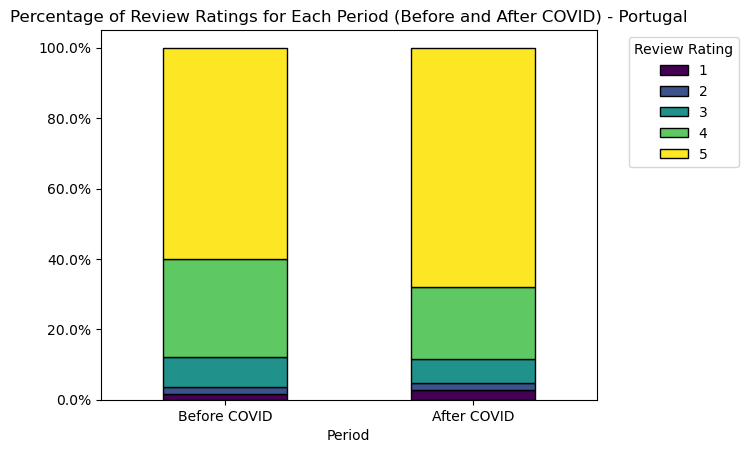

In [52]:
Period_reviewRating = portugal_df.groupby(['Period', 'reviewRating']).size().reset_index(name='reviewRatingCount')

# Total reviews for each period
Period_total_reviewRating = Period_reviewRating.groupby('Period')['reviewRatingCount'].sum().reset_index(name='totalReviewRatings')

# % of each review for each period
reviewRating_percentages = pd.merge(Period_reviewRating, Period_total_reviewRating, on='Period')
reviewRating_percentages['percentage'] = (reviewRating_percentages['reviewRatingCount'] / reviewRating_percentages['totalReviewRatings']) * 100

# Plot 
reviewRating_percentages_pivot = reviewRating_percentages.pivot(index='Period', columns='reviewRating', values='percentage')
plt.figure(figsize=(15, 6))
ax = reviewRating_percentages_pivot.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))  
plt.title('Percentage of Review Ratings for Each Period (Before and After COVID) - Portugal')
plt.xlabel('Period')
plt.xticks(rotation=0)  # Ajuste o ângulo de rotação se necessário
plt.legend(title='Review Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [53]:
reviewRating_percentages_pivot

reviewRating         1         2         3          4          5
Period                                                          
Before COVID  1.598318  1.997897  8.643533  27.781283  59.978970
After COVID   2.857143  1.904762  6.666667  20.476190  68.095238

In [54]:
average_before_covid = portugal_df[portugal_df['Period'] == 'Before COVID']['reviewRating'].mean()
average_after_covid = portugal_df[portugal_df['Period'] == 'After COVID']['reviewRating'].mean()

print("Average Review Rating Before COVID:", average_before_covid)
print("Average Review Rating After COVID:", average_after_covid)

Average Review Rating Before COVID: 4.425446898002103
Average Review Rating After COVID: 4.4904761904761905


There has been a noticeable increase in extreme reviews during the analyzed period, particularly with a significant surge in '5' ratings. While there is a mild uptick in '1' ratings, it may not be as pronounced. On average, the pandemic appears to have played in favor of Portugal's reputation in terms of rating. The heightened positive experiences, reflected in increased '5' ratings, seem to outweigh the relatively modest increase in '1' ratings. This suggests that, on the whole, the impact of the pandemic has contributed positively to Portugal's overall rating reputation.

## Frequent Itemset Associations (Market Basket Analysis): 

In [55]:
df_filtered.head(1)

localID  globalRating  positionOnRanking  totalReviews  \
0  MAG013           4.5                  1         34353   

                               userName  userContributions tripType  \
0  #travelswithhugodog@ajotraveller2016                 81      NaN   

  reviewVisited  reviewRating userISOCode         Name  Country ISO  Year  \
0    2019-07-01             5          GB  Grand Place  Belgium  BE  2019   

   Month  Day        Period    user_country user_iso_alpha3  Season  
0      7    1  Before COVID  United Kingdom             GBR  Summer

Removing users that do not reach the minimum support in reviews - 7 - we experiment 

In [56]:
# number of reviews for each user
user_review_counts = df_filtered['userName'].value_counts().reset_index()
user_review_counts.columns = ['userName', 'reviewCount']

# keep only users with more than x reviews
users_with_multiple_reviews = user_review_counts[user_review_counts['reviewCount'] > 7]
df_filtered_multiple_reviews = df_filtered[df_filtered['userName'].isin(users_with_multiple_reviews['userName'])].copy()

#### - Patterns of Countries frequently visited together

In [57]:
ptISO = pd.pivot_table(df_filtered_multiple_reviews[['userName','Country']],
                    index='userName',                                
                    columns='Country',                       
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)   

frequent_itemsetsISO = apriori(ptISO.astype('bool'), min_support=0.01, use_colnames=True)

# Generate the association rules - by support
rulesSupportISO = association_rules(frequent_itemsetsISO, metric="support", min_threshold=0.11) 
rulesSupportISO.sort_values(by='confidence', ascending=False, inplace=True)
top_rules_iso = rulesSupportISO.nlargest(10, 'confidence')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
top_rules_iso

antecedents consequents   support  confidence      lift
15  (Portugal)     (Spain)  0.269231    0.800000  1.363934
4   (Scotland)   (England)  0.182692    0.760000  2.026667
0    (Croatia)     (Italy)  0.115385    0.545455  1.620779
3      (Italy)   (England)  0.182692    0.542857  1.447619
17  (Scotland)     (Spain)  0.125000    0.520000  0.886557
11    (France)     (Spain)  0.134615    0.500000  0.852459
5    (England)  (Scotland)  0.182692    0.487179  2.026667
2    (England)     (Italy)  0.182692    0.487179  1.447619
13     (Italy)     (Spain)  0.163462    0.485714  0.828103
8     (France)     (Italy)  0.125000    0.464286  1.379592

Rule 1: (Portugal) -> (Spain)
Approximately 26.92% of users who visited Portugal also visited Spain. The high confidence of 80.00% indicates a strong likelihood that a user visiting Portugal also explored Spain. The lift value of 1.36 suggests a positive association, making the probability of visiting Spain 1.36 times higher when a user visits Portugal compared to the overall probability.

Rule 2: (Scotland) -> (England)
Around 18.27% of users who visited Scotland also visited England. With a confidence level of 76.00%, there is a significant probability that a user visiting Scotland also visited England. The lift value of 2.03 indicates a substantial increase in the likelihood of visiting England compared to the overall probability.

Rule 3: (Croatia) -> (Italy)
About 11.54% of users who visited Croatia also visited Italy. The confidence of 54.55% suggests a moderate probability that a user visiting Croatia also explored Italy. The lift value of 1.62 signifies a positive association, making the probability of visiting Italy 1.62 times higher when a user visits Croatia compared to the overall probability.

Test for users with more than 8 reviews proves to be an improvement:

In [58]:
users_with_multiple_reviews2 = user_review_counts[user_review_counts['reviewCount'] > 8]
df_filtered_multiple_reviews2 = df_filtered[df_filtered['userName'].isin(users_with_multiple_reviews2['userName'])].copy()

In [59]:
ptISO10 = pd.pivot_table(df_filtered_multiple_reviews2[['userName','Country']],
                    index='userName',                                
                    columns='Country',                       
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)   

frequent_itemsetsISO10 = apriori(ptISO10.astype('bool'), min_support=0.01, use_colnames=True)

# Generate the association rules - by support
rulesSupportISO10 = association_rules(frequent_itemsetsISO10, metric="support", min_threshold=0.11) 
rulesSupportISO10.sort_values(by='confidence', ascending=False, inplace=True)
top_rules_iso10 = rulesSupportISO10.nlargest(10, 'confidence')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
top_rules_iso10

antecedents consequents   support  confidence      lift
34  (Scotland, Italy)   (England)  0.122807    0.875000  2.267045
20           (Poland)     (Italy)  0.157895    0.818182  2.027668
29         (Portugal)     (Spain)  0.333333    0.791667  1.219595
1           (Croatia)     (Spain)  0.140351    0.727273  1.120393
8          (Scotland)   (England)  0.210526    0.705882  1.828877
31         (Scotland)     (Spain)  0.192982    0.647059  0.996820
18           (Poland)   (Hungary)  0.122807    0.636364  3.022727
44  (Spain, Scotland)   (England)  0.122807    0.636364  1.648760
39   (Italy, England)     (Spain)  0.122807    0.636364  0.980344
33   (Italy, England)  (Scotland)  0.122807    0.636364  2.133690

#### - Patterns of attractions frequently visited together:

In [60]:
# Creating a binary matrix indicating whether each user visited each attraction
binary_matrix = pd.pivot_table(df_filtered_multiple_reviews[['userName', 'localID']],
                                index='userName', 
                                columns='localID',
                                aggfunc=lambda x: 1 if len(x) > 0 else 0).fillna(0).astype('bool')

# Apriori algorithm
frequent_itemsets = apriori(binary_matrix, min_support=0.01, use_colnames=True)

# association rules based on support
rules_support = association_rules(frequent_itemsets, metric="support", min_threshold=0.2)
rules_support.sort_values(by='confidence', ascending=False, inplace=True)

# Display the top 10 rules by confidence
top_rules = rules_support.nlargest(10, 'confidence')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print("Rules by Confidence:")
top_rules

Rules by Confidence:


antecedents consequents   support  confidence      lift
2    (MAG004)    (MAG001)  0.211538    0.956522  2.486957
6    (MAG012)    (MAG019)  0.201923    0.913043  3.516908
4    (MAG023)    (MAG001)  0.201923    0.875000  2.275000
0    (MAG002)    (MAG001)  0.230769    0.827586  2.151724
7    (MAG019)    (MAG012)  0.201923    0.777778  3.516908
1    (MAG001)    (MAG002)  0.230769    0.600000  2.151724
3    (MAG001)    (MAG004)  0.211538    0.550000  2.486957
5    (MAG001)    (MAG023)  0.201923    0.525000  2.275000

In [61]:
attraction_codes = ['MAG004', 'MAG002','MAG001', 'MAG023', 'MAG012', 'MAG019']
for code in attraction_codes:
    attraction_name = df_filtered_multiple_reviews[df_filtered_multiple_reviews['localID'] == code]['Name'].iloc[0]
    print(f"{code}: {attraction_name}")

MAG004: Casa Batllo
MAG002: Parc Guell
MAG001: Basilica of the Sagrada Familia
MAG023: Casa Milà - La Pedrera
MAG012: Real Alcazar de Sevilla
MAG019: Catedral de Sevilla


### - Portugal 

To overcome the Spain 'domination' we are going to analyse the patterns specifically for Portugal:

In [65]:
portugal = df_filtered_multiple_reviews[df_filtered_multiple_reviews['Country'] == 'Portugal']

In [68]:
binary_matrixpt = pd.pivot_table(portugal[['userName', 'localID']],
                                index='userName', 
                                columns='localID',
                                aggfunc=lambda x: 1 if len(x) > 0 else 0).fillna(0).astype('bool')

frequent_Att_setspt = apriori(binary_matrixpt, min_support=0.01, use_colnames=True)
rules_supportpt = association_rules(frequent_Att_setspt, metric="support", min_threshold=0.2)
rules_supportpt.sort_values(by='confidence', ascending=False, inplace=True)
top_rulespt = rules_supportpt.nlargest(10, 'confidence')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print("Rules by Confidence:")
top_rulespt

Rules by Confidence:


antecedents       consequents   support  confidence      lift
9           (MAG047)          (MAG014)  0.228571    0.888889  1.414141
5           (MAG047)          (MAG010)  0.228571    0.888889  1.296296
20  (MAG014, MAG047)          (MAG010)  0.200000    0.875000  1.276042
19  (MAG010, MAG047)          (MAG014)  0.200000    0.875000  1.392045
14  (MAG032, MAG014)          (MAG010)  0.285714    0.833333  1.215278
1           (MAG014)          (MAG010)  0.514286    0.818182  1.193182
23          (MAG047)  (MAG010, MAG014)  0.200000    0.777778  1.512346
11          (MAG047)          (MAG032)  0.200000    0.777778  1.512346
13  (MAG010, MAG032)          (MAG014)  0.285714    0.769231  1.223776
0           (MAG010)          (MAG014)  0.514286    0.750000  1.193182

In [64]:
attraction_pt = ['MAG047', 'MAG014', 'MAG010', 'MAG032']
for code in attraction_pt:
    attraction_name = df_filtered_multiple_reviews[df_filtered_multiple_reviews['localID'] == code]['Name'].iloc[0]
    print(f"{code}: {attraction_name}")

MAG047: Quinta da Regaleira
MAG014: Mosteiro dos Jeronimos
MAG010: Torre de Belém
MAG032: Park and National Palace of Pena
